# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.302571,True,6.369490
1,0.487572,True,6.590777
2,0.928295,True,8.659969
3,-1.416513,False,-2.366209
4,-1.251058,False,-1.347237
...,...,...,...
995,-0.675823,True,4.520989
996,0.762766,True,6.571076
997,-0.552114,False,-1.395625
998,0.573109,True,7.270368


<AxesSubplot: xlabel='v0'>

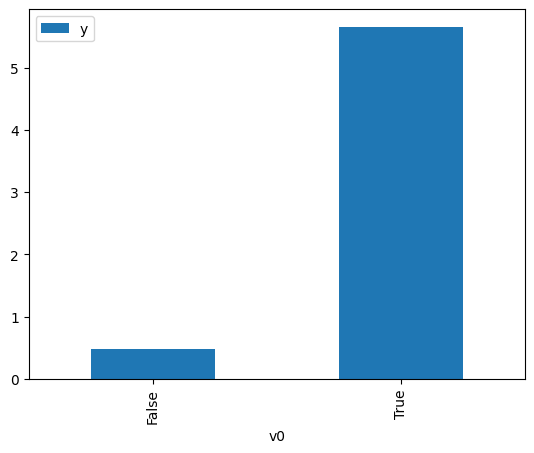

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

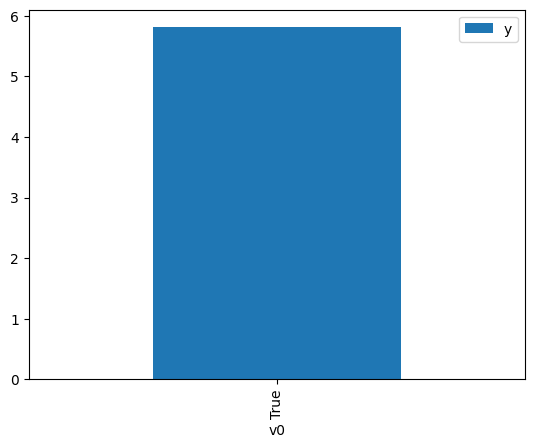

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.984390,False,-2.065663,0.727130,1.375269
1,0.900073,False,1.739081,0.284744,3.511923
2,-1.085824,False,-2.384810,0.746956,1.338767
3,0.434081,False,0.541987,0.389140,2.569768
4,-1.053114,False,-1.956994,0.740668,1.350132
...,...,...,...,...,...
995,1.541991,False,3.519773,0.172408,5.800187
996,-0.126072,False,1.005904,0.528516,1.892090
997,-0.327738,False,-1.665187,0.578749,1.727864
998,0.530329,False,-0.442212,0.366322,2.729841


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.644264,True,4.049065,0.345931,2.890747
1,-0.003592,True,4.620328,0.502344,1.990667
2,-0.487040,True,3.732007,0.382641,2.613417
3,1.938819,True,10.390138,0.877503,1.139597
4,1.331330,True,7.103606,0.795130,1.257657
...,...,...,...,...,...
995,-1.353607,True,1.210503,0.205446,4.867467
996,0.447385,True,7.105042,0.614046,1.628543
997,0.285074,True,5.872214,0.574589,1.740373
998,0.266034,True,6.902793,0.569887,1.754732


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          1.390e+04
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:30:49   Log-Likelihood:                         -1405.6
No. Observations:                1000   AIC:                                      2815.
Df Residuals:                     998   BIC:                                      2825.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8988      0.033     56.689      0.000       1.833       1.965
x2             5.0744      0.048    106.134      0.000       4.981       5.168
==============================================================================
Omnibus:                        0.884   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.950
Skew:                           0.030   Prob(JB):                        0.622
Kurtosis:                       2.862   Cond. No.                         1.96
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""